In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()

## Import preprocessed data

In [2]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [3]:
df.tail()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242
8816,2.034397,1.649574,0.756850,0.427220,-0.653437,-0.291699,-0.229339,-0.101374,0.149274,3.394598,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.231014,1.394854,0.815823


In [4]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [5]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## K-Means Clustering
What is K-Means clustering? How does it work?

### How is it computed?
![](../figures/kmeans.png)

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

### How to apply K-Means clustering?

In [6]:
kmclust = KMeans(n_clusters=5,init='random',n_init=1,random_state=None)
# the fit method
kmclust.fit(df[metric_features])

KMeans(init='random', n_clusters=5, n_init=1)

In [7]:
# the predict method
kmclust.predict(df[metric_features])

array([2, 2, 3, ..., 0, 2, 1])

In [8]:
# the transform method
kmclust.transform(df[metric_features])

array([[3.58476993, 3.17221635, 1.24156203, 4.94586375, 3.96107198],
       [4.52419985, 3.4992137 , 2.27969801, 6.12064132, 3.99408316],
       [3.32665617, 5.65761624, 5.06324051, 2.6304437 , 4.46037892],
       ...,
       [2.17327712, 4.13226166, 4.16557057, 3.74135459, 2.50975922],
       [2.90085732, 3.0176872 , 2.31451256, 4.06837635, 3.40179619],
       [5.84284722, 2.56403086, 4.0114396 , 7.00949002, 5.0630703 ]])

### How can we improve the initialization step?

In [9]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [10]:
kmclust.predict(df[metric_features])

array([4, 4, 7, ..., 6, 2, 0])

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

**Empirical evaluation of the impact of k-means initialization:**

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py

### Defining the number of clusters:

In [11]:
range_clusters = range(2,16)

In [12]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    # fit the clusterer
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

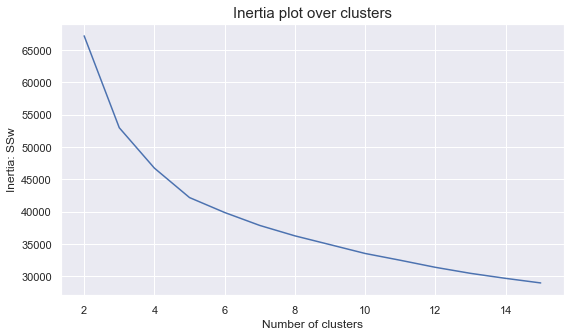

In [13]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia,index=range_clusters))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.2216925624241448
For n_clusters = 3, the average silhouette_score is : 0.2369353224710234
For n_clusters = 4, the average silhouette_score is : 0.21033233671075402
For n_clusters = 5, the average silhouette_score is : 0.19514283937028068
For n_clusters = 6, the average silhouette_score is : 0.1873452674532108
For n_clusters = 7, the average silhouette_score is : 0.16982834399767657
For n_clusters = 8, the average silhouette_score is : 0.1667159854889826
For n_clusters = 9, the average silhouette_score is : 0.15764656866937532
For n_clusters = 10, the average silhouette_score is : 0.15124529702999032
For n_clusters = 11, the average silhouette_score is : 0.1451157603301975
For n_clusters = 12, the average silhouette_score is : 0.1493556493800688
For n_clusters = 13, the average silhouette_score is : 0.15031255308722472
For n_clusters = 14, the average silhouette_score is : 0.15123004667498213
For n_clusters = 15, the average silhou

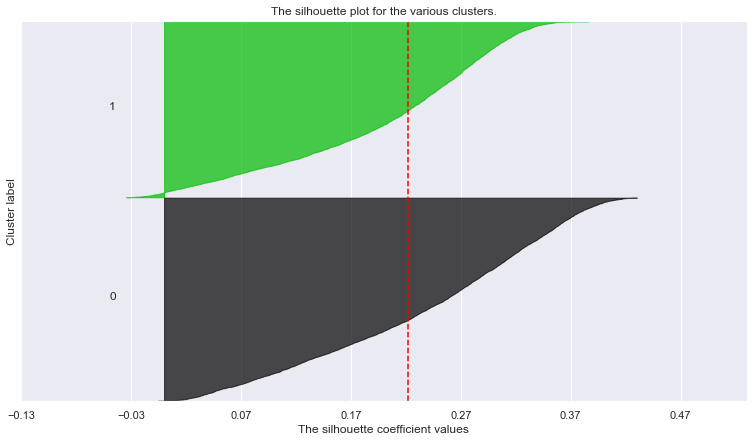

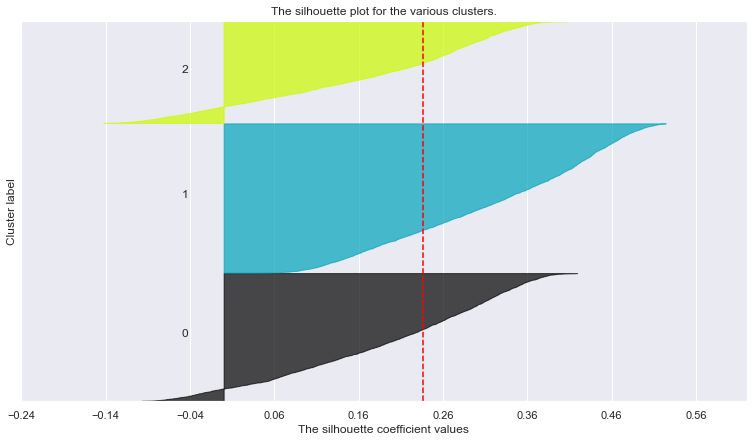

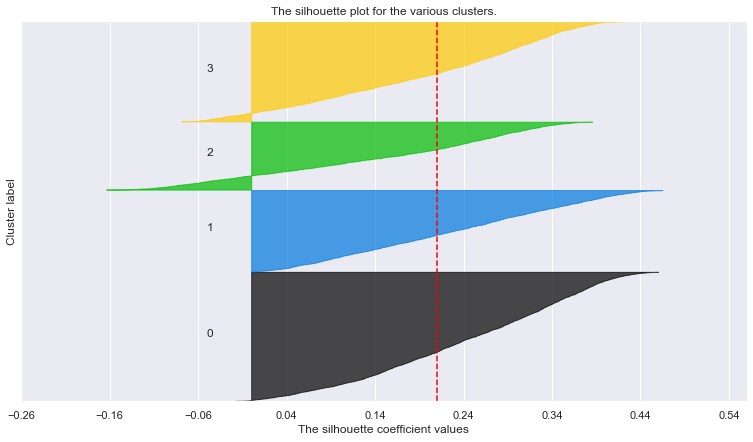

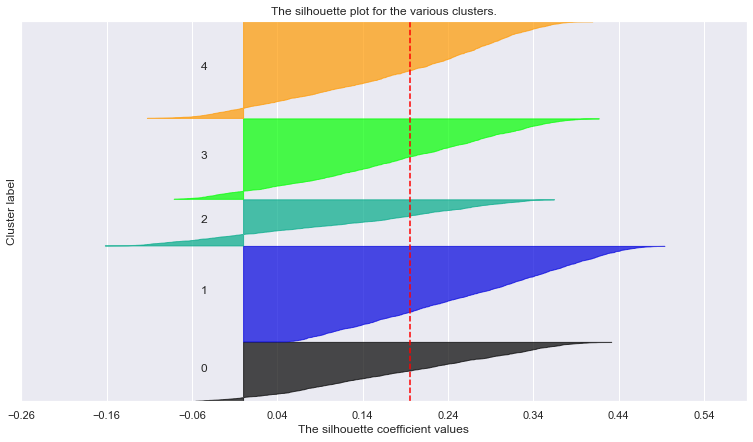

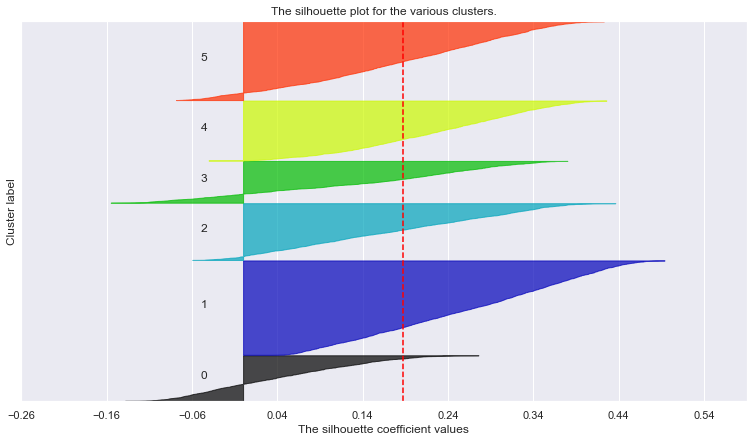

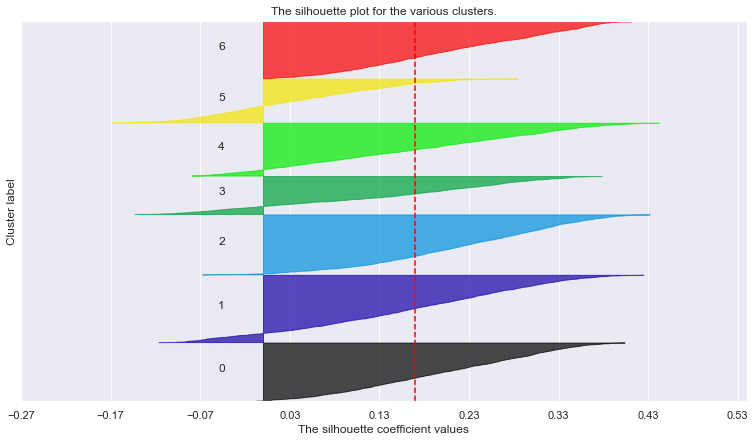

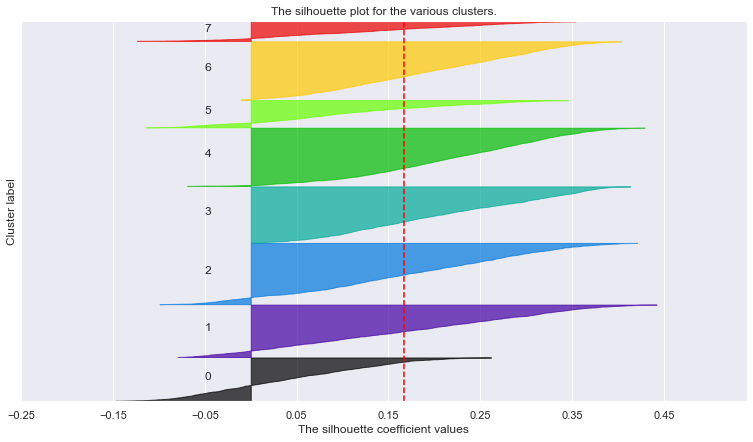

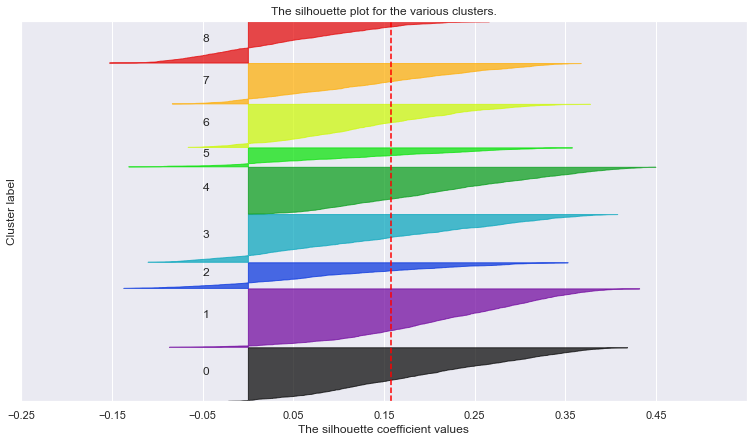

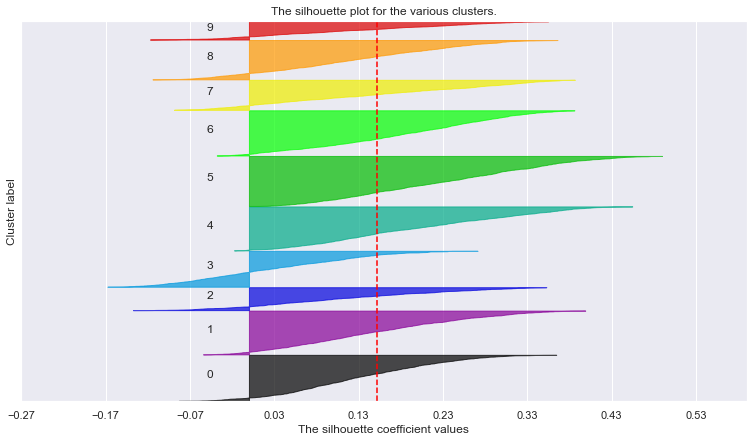

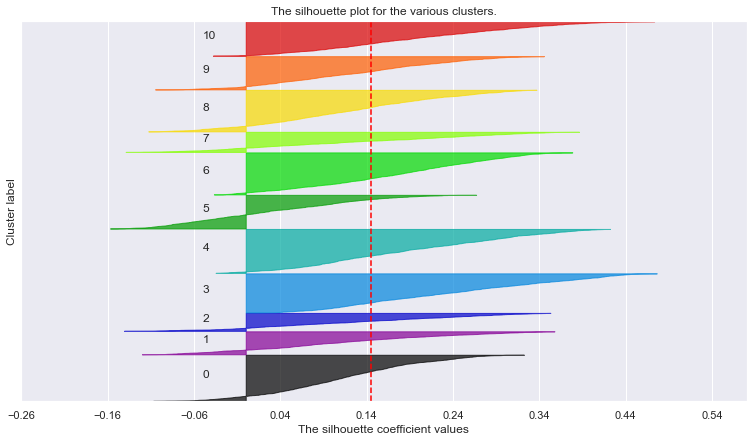

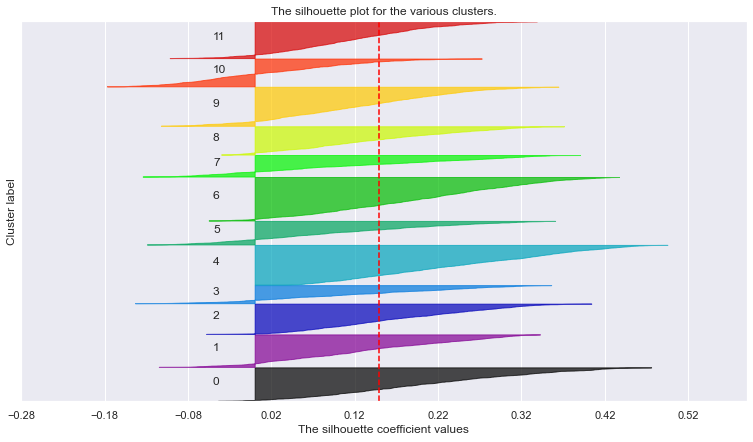

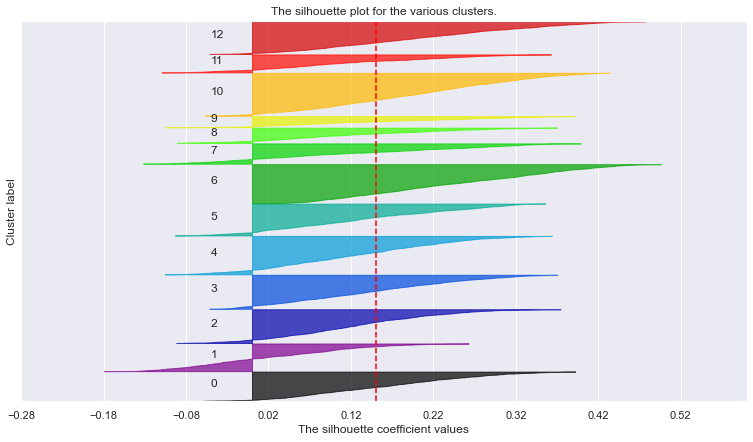

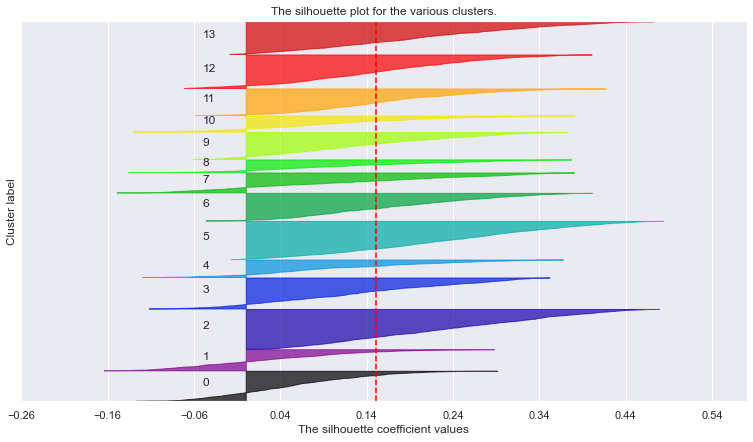

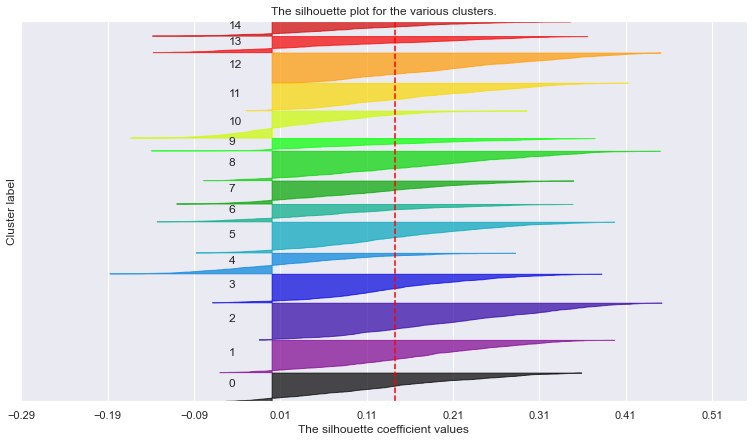

In [14]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    #if nclus == 1:
     #   continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features],cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features],cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

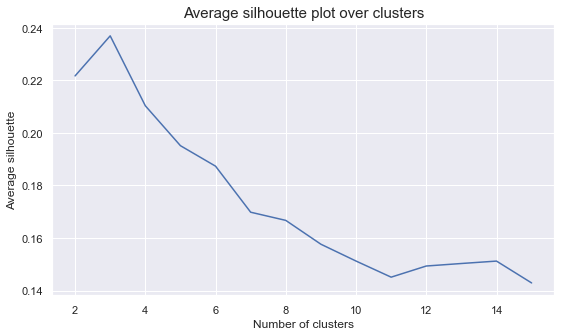

In [15]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(avg_silhouette,index=range_clusters))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [16]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([0, 0, 2, ..., 1, 0, 0])

In [17]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
labels,,,,,,,,,,,,,,,,,,,,,
0,1.053034,1.060879,-0.070855,-0.228810,0.037782,0.372862,0.041329,0.002771,-1.030011,0.686769,...,0.110588,0.640000,0.360336,0.080672,0.087731,0.462521,0.369076,1.180243,1.597675,-0.120015
1,-0.191965,-0.331728,-0.007914,0.897355,-0.580771,-0.642601,-0.587273,-0.565304,0.408327,-0.064700,...,0.024460,0.640288,0.936115,0.297842,0.284604,0.350791,0.062446,0.670007,-1.439862,0.076779
2,-1.041697,-0.846371,0.100674,-1.029827,0.805144,0.474767,0.810234,0.826442,0.695118,-0.768190,...,0.008872,0.652725,0.843684,0.328686,0.334178,0.325306,0.001267,-2.467045,0.105804,0.038124


### How can we combine the 2 algorithms?

## Exercise:
**Apply Hierarchical Clustering and K-means on the Principal Components.**

Choose the appropriate parameters and number of clusters for each algorithm and interpret each cluster based on the Principal Components interpretation:

#### Options:
- First K-Means, then Hierarchical
- First Hierarchical, then K-Means

In [18]:
range2_clusters=range(40,52)

### K-means

In [19]:
inertia = []
for n_clus in range2_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    # fit the clusterer
    kmclust.fit(df[pc_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

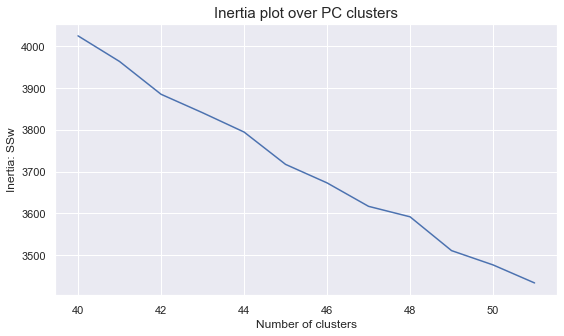

In [20]:
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia,index=range2_clusters))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over PC clusters", size=15)
plt.show()

For n_clusters = 40, the average silhouette_score is : 0.24140267949666
For n_clusters = 41, the average silhouette_score is : 0.24161070323349612
For n_clusters = 42, the average silhouette_score is : 0.24487021407527695
For n_clusters = 43, the average silhouette_score is : 0.24237437778011528
For n_clusters = 44, the average silhouette_score is : 0.23799705472388852
For n_clusters = 45, the average silhouette_score is : 0.24422260634517243
For n_clusters = 46, the average silhouette_score is : 0.2415557907426841
For n_clusters = 47, the average silhouette_score is : 0.24526944477775597
For n_clusters = 48, the average silhouette_score is : 0.2401649113938898
For n_clusters = 49, the average silhouette_score is : 0.2426037999021834
For n_clusters = 50, the average silhouette_score is : 0.24096972462652977
For n_clusters = 51, the average silhouette_score is : 0.24039503494503403


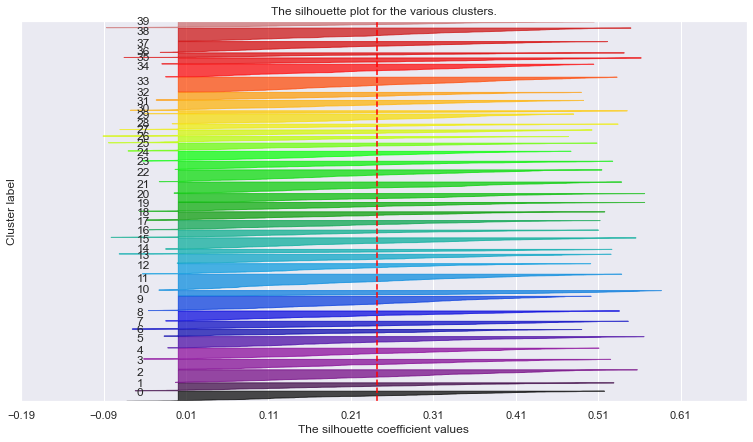

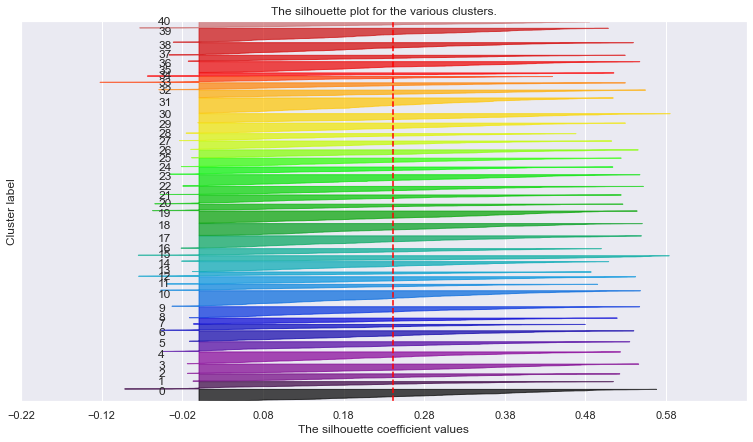

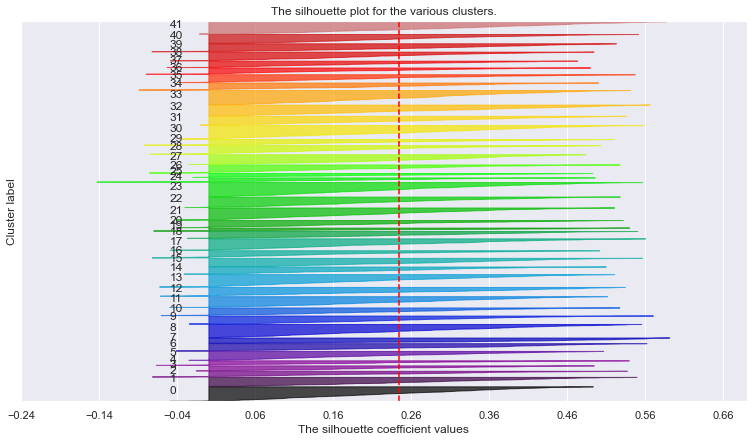

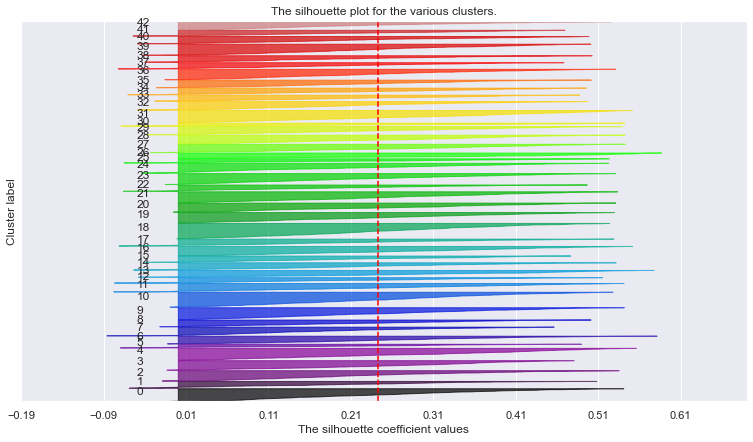

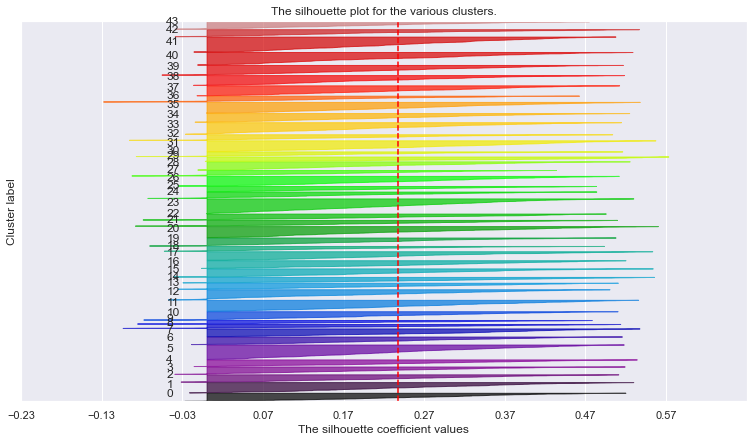

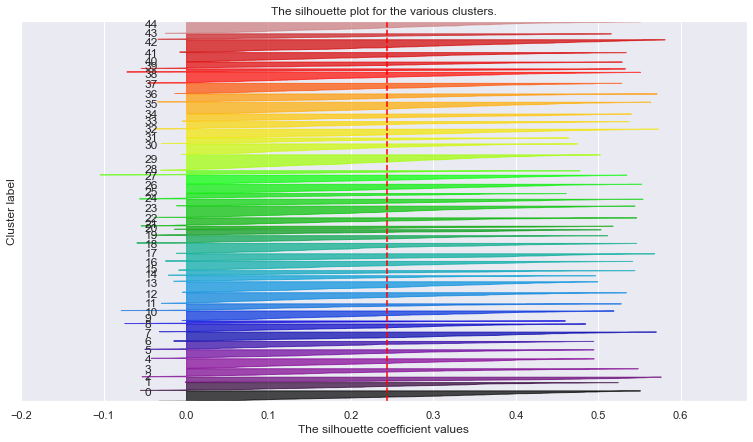

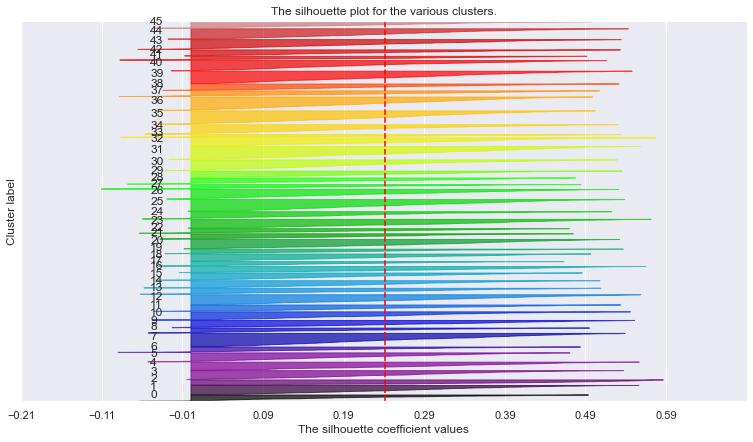

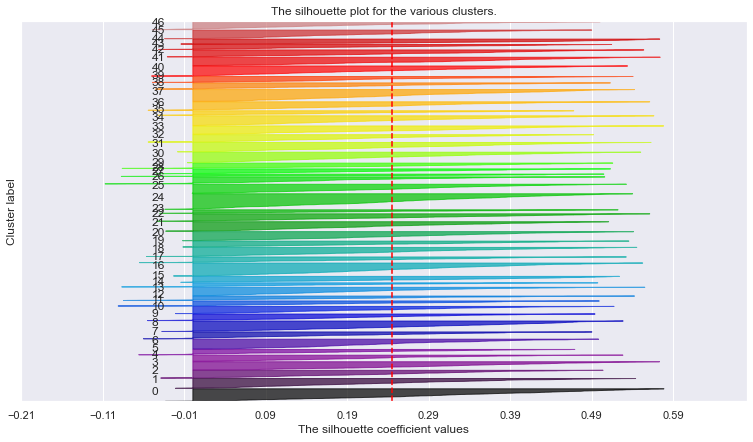

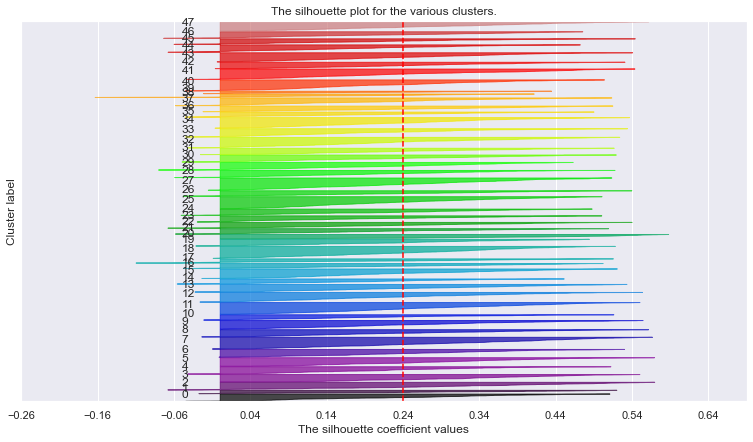

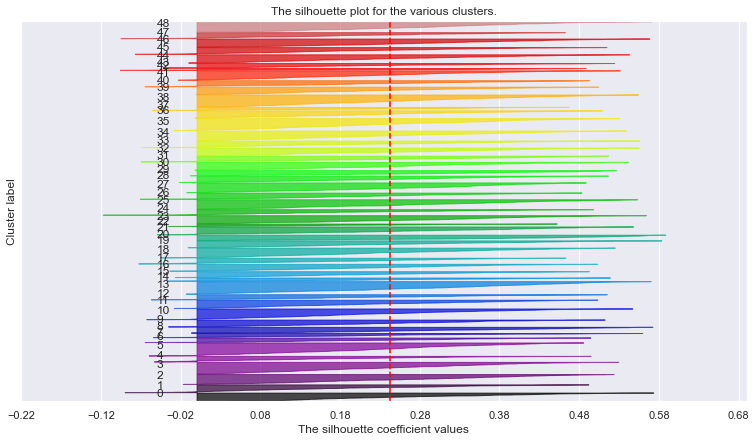

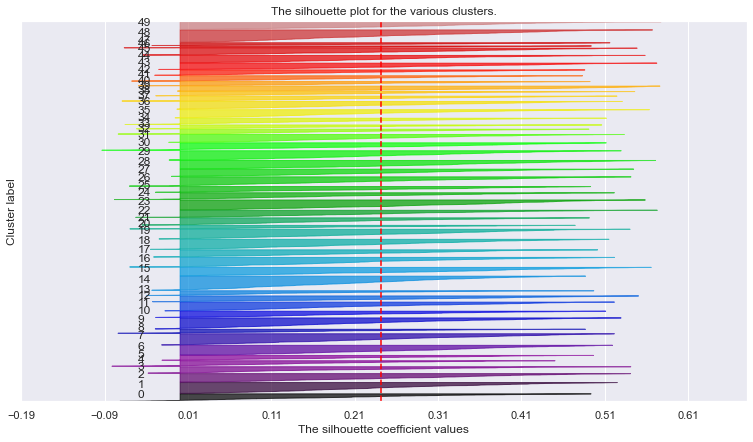

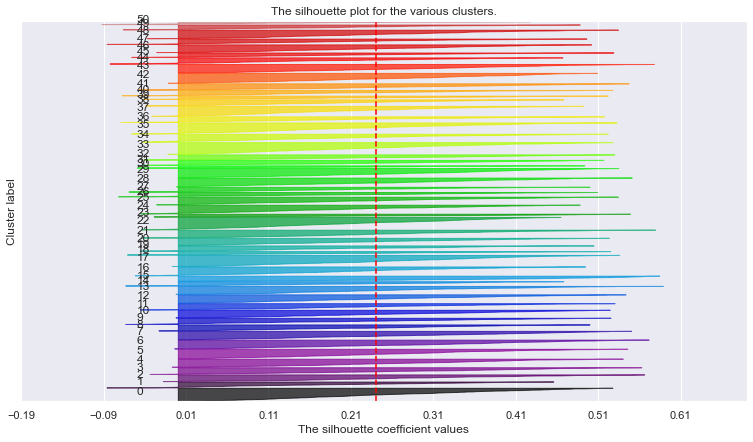

In [21]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range2_clusters:
    # Skip nclus == 1
    #if nclus == 1:
     #   continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[pc_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[pc_features],cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[pc_features],cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[pc_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

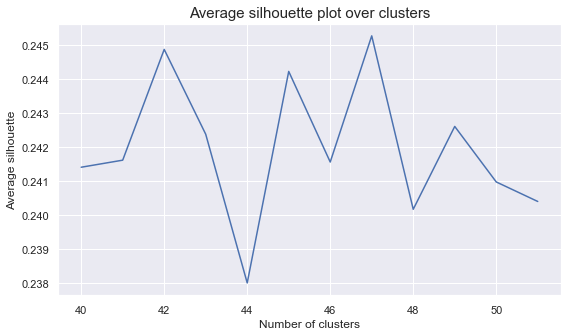

In [22]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(avg_silhouette,index=range2_clusters))
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [23]:
# final cluster solution
number_clusters = 45
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[pc_features])
km_labels


array([34, 27, 40, ..., 12, 41, 43])

In [24]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels_k')), axis=1)
#df_concat.groupby('labels').mean()
df_concat

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,labels_k
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,34
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,27
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,40
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,3
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,3
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,5
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,12
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,41


In [25]:
pc_features_2 = pc_features.append(pd.Index(['labels_k']))

In [26]:
df_concat[pc_features_2]

,PC0,PC1,PC2,labels_k
0,0.896356,1.937697,-1.120781,34
1,1.981092,1.421498,-0.785625,27
2,-2.813108,-0.381440,0.780867,40
3,1.247013,0.514177,1.302203,3
4,1.781920,0.704805,0.443376,26
...,...,...,...,...
8812,1.162525,0.372854,0.982963,3
8813,2.003026,-0.083121,1.428619,5
8814,-1.002171,-1.301747,0.423851,12
8815,0.130573,0.959962,-0.332242,41


In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


In [28]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df_concat[pc_features_2])
hc_labels

array([0, 0, 3, ..., 1, 3, 3], dtype=int64)

In [29]:
# Computing SST
X = df_concat[pc_features_2].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True])

In [49]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

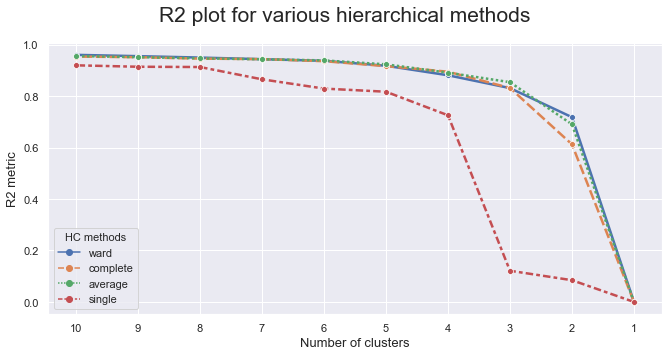

In [31]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df_concat[pc_features_2], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [32]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_concat[pc_features])

array([7923, 6285, 7894, ...,    3,    1,    0], dtype=int64)

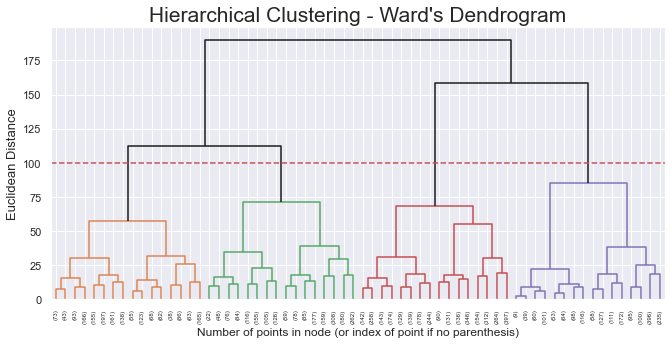

In [33]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

end??


In [34]:
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df_concat[pc_features_2])

In [35]:
hc4_labels

array([1, 1, 3, ..., 0, 3, 3], dtype=int64)

In [36]:
# Characterizing the 4 clusters
df_concat_2 = pd.concat((df_concat, pd.Series(hc4_labels, name='labels_h')), axis=1)
df_concat_2.groupby('labels_h').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,labels_k
labels_h,,,,,,,,,,,,,,,,,,,,,
0,-0.260814,-0.251937,-0.034377,-0.213594,0.158645,0.119492,0.163143,0.148276,0.193203,-0.260483,...,0.633569,0.755610,0.258838,0.266831,0.363357,0.105749,-0.599718,-0.065724,-0.027964,7.820166
1,0.105569,-0.018480,0.112820,0.248866,-0.201504,-0.103918,-0.213110,-0.194321,-0.120371,-0.043736,...,0.657932,0.720963,0.247521,0.225212,0.379603,0.143059,0.348971,-0.236688,-0.141710,32.138456
2,0.310518,0.436437,-0.033030,-0.296299,0.192743,0.200157,0.211883,0.189656,-0.268696,0.372032,...,0.636422,0.592971,0.144409,0.163578,0.423642,0.264537,0.169700,0.820047,0.105828,20.880511
3,0.054757,0.160607,-0.131987,0.387858,-0.211632,-0.347649,-0.221686,-0.196080,0.112295,0.330751,...,0.645957,0.765957,0.243404,0.239149,0.381277,0.132766,0.595582,-0.341417,0.277050,41.954894


In [37]:
#df_concat_2.drop('labels_h',axis=1,inplace=True)

In [38]:
df_concat_2

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,labels_k,labels_h
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,34,1
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,27,1
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,40,3
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,3,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,3,0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,5,0
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,12,0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,41,3


In [ ]:
plt.scatter(df_concat_2[:,0],df_concat_2[:,1])
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5833313893669031
For n_clusters = 3, the average silhouette_score is : 0.4485898477161707
For n_clusters = 4, the average silhouette_score is : 0.4163917872899515
For n_clusters = 5, the average silhouette_score is : 0.4075979901632568
For n_clusters = 6, the average silhouette_score is : 0.41525828761650513
For n_clusters = 7, the average silhouette_score is : 0.37888848201804437
For n_clusters = 8, the average silhouette_score is : 0.38760215550466787


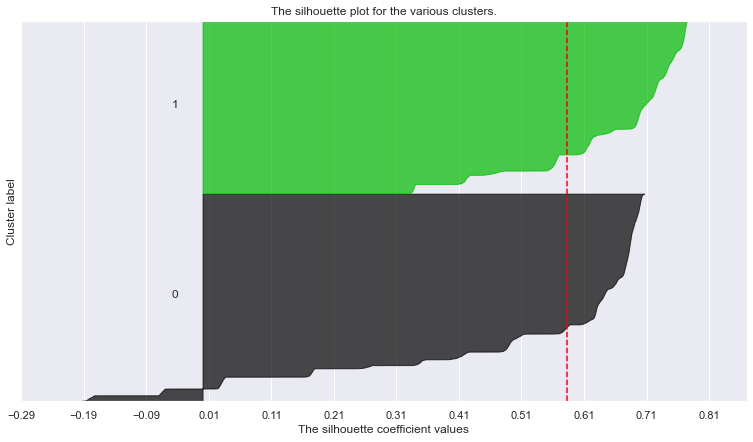

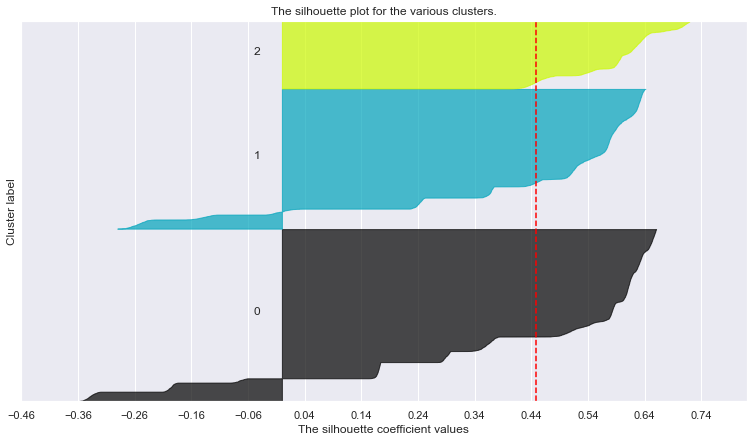

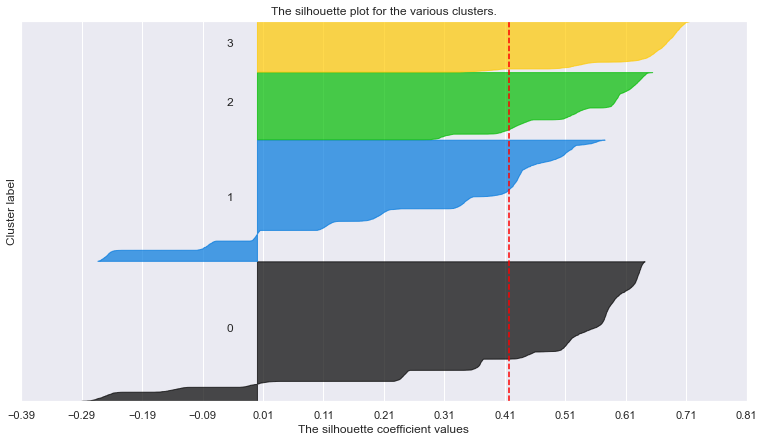

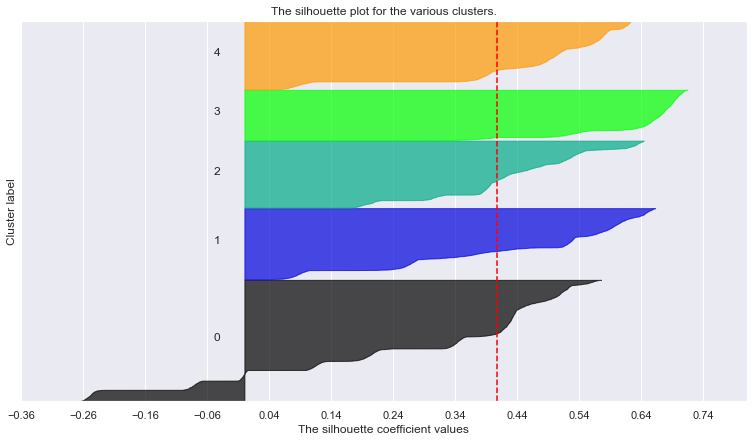

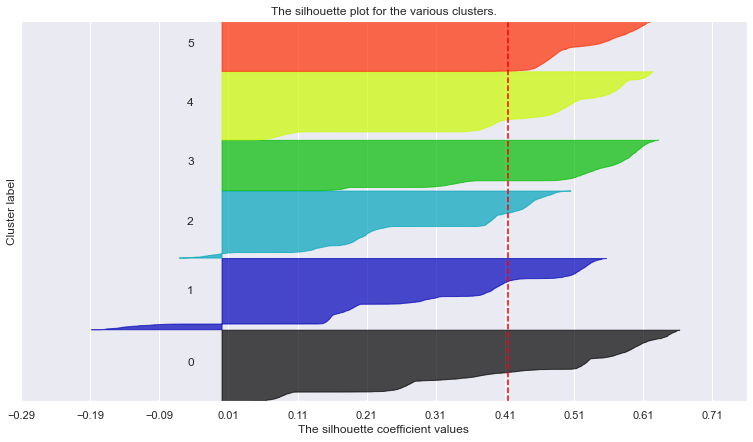

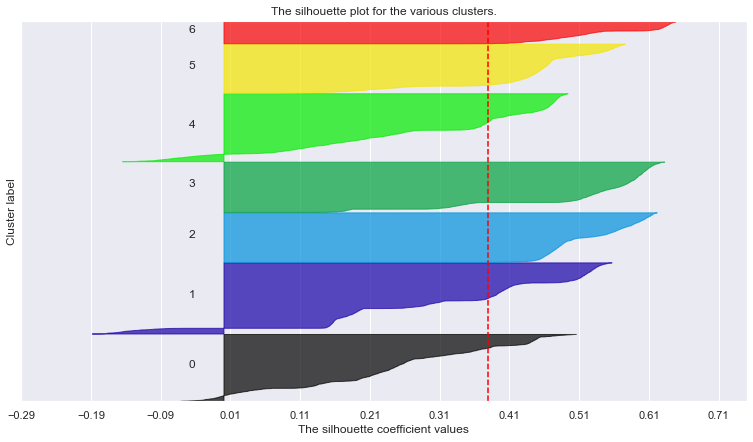

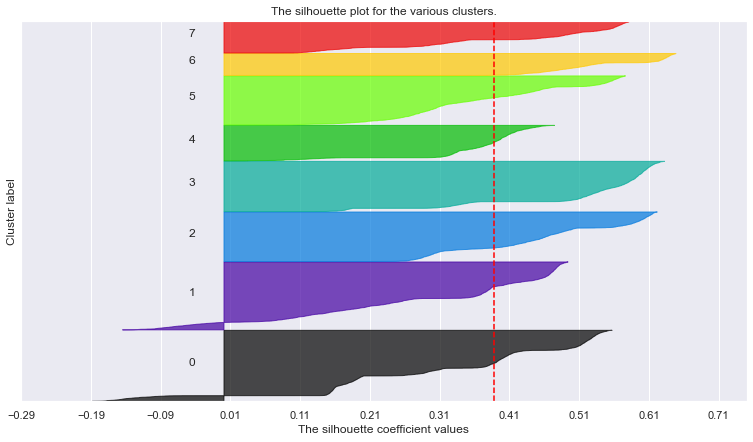

In [61]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range(2,9):
    # Skip nclus == 1
    #if nclus == 1:
     #   continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    hhclust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=nclus)
    cluster_labels = hhclust.fit_predict(df_concat[pc_features_2])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_concat[pc_features_2],cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_concat[pc_features_2],cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_concat[pc_features_2]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

In [59]:
cluster_labels

array([7953, 6377, 7924, ...,    4,    1,    0], dtype=int64)